In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import itertools
import pprint

import orbax.checkpoint
import numpy as np
import jax
import jax.numpy as jnp
import torch.utils.data.dataloader
import tensorflow as tf
import sqlalchemy as sa
import seaborn as sns
sns.set_theme(style='whitegrid', font_scale=1.3, palette=sns.color_palette(),)
import pandas as pd
import matplotlib.pyplot as plt

from userdiffusion import samplers, unet
from userfm import cs, datasets, diffusion, sde_diffusion, flow_matching, utils, main as main_module, plots

2025-01-19 01:49:51.282265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737251391.300405    1737 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737251391.306084    1737 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# somehow, this line of code prevents a segmentation fault in nn.Dense
# when calling model.init
tf.config.experimental.set_visible_devices([], 'GPU')

In [4]:
engine = cs.get_engine()
cs.create_all(engine)
session = cs.orm.Session(engine)
session.begin()

In [5]:
config_alt_ids = {
    # Lorenz
    # ('3vutgqt1', 'Diffusion (VE SDE)'): {},
    # ('fba4g7bp', 'Flow Matching (OT)'): {'sample': {'use_score': False}},
    # ('eug367ja', 'Flow Matching (VE)'): {'sample': {'use_score': False}},
    # ('eug367ja', 'Flow Matching (VE Score)'): {'sample': {'use_score': True}},
    # FitzHughNagumo
    ('wyrwide1', 'Diffusion (VE SDE)'): {},
    ('gcior3bc', 'Flow Matching (OT)'): {'sample': {'use_score': False}},
    ('tybh75p1', 'Flow Matching (VE)'): {'sample': {'use_score': False}},
    ('tybh75p1', 'Flow Matching (VE Score)'): {'sample': {'use_score': True}},
}

In [6]:
cfgs = session.execute(sa.select(cs.Config).where(cs.Config.alt_id.in_([c[0] for c in config_alt_ids])))
cfgs = {c.alt_id: c for (c,) in cfgs}
reference_cfg = cfgs[next(iter(cfgs.keys()))]

In [7]:
key = jax.random.key(reference_cfg.rng_seed)

In [8]:
key, key_dataset = jax.random.split(key)
ds = datasets.get_dataset(reference_cfg.dataset, key=key_dataset)
splits = datasets.split_dataset(reference_cfg.dataset, ds)
dataloaders = {}
for n, s in splits.items():
    dataloaders[n] = torch.utils.data.dataloader.DataLoader(
        list(tf.data.Dataset.from_tensor_slices(s).batch(reference_cfg.dataset.batch_size).as_numpy_iterator()),
        batch_size=1,
        collate_fn=lambda x: x[0],
    )
data_std = splits['train'].std()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:37<00:00,  5.14it/s]


In [9]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
x_sample = next(iter(dataloaders['train']))

cfg_info = {}
for k in config_alt_ids:
    cfg = cfgs[k[0]]
    assert cfg.rng_seed == reference_cfg.rng_seed
    assert cfg.dataset == reference_cfg.dataset

    cfg_unet = unet.unet_64_config(
        splits['train'].shape[-1],
        base_channels=cfg.model.architecture.base_channel_count,
        attention=cfg.model.architecture.attention,
    )
    model = unet.UNet(cfg_unet)
    
    key, key_jaxlightning = jax.random.split(key)
    if isinstance(cfg.model, cs.ModelDiffusion):
        jax_lightning = diffusion.JaxLightning(cfg, key_jaxlightning, dataloaders, data_std, None, model)
    elif isinstance(cfg.model, cs.ModelFlowMatching):
        jax_lightning = flow_matching.JaxLightning(cfg, key_jaxlightning, dataloaders, data_std, None, model)
    else:
        raise ValueError(f'Unknown model: {cfg.model}')
        
    jax_lightning.params = orbax_checkpointer.restore(cfg.run_dir/'last')
    jax_lightning.params_ema = orbax_checkpointer.restore(cfg.run_dir/'last_ema')

    cfg_info[k] = dict(
        cfg=cfg,
        jax_lightning=jax_lightning,
    )

/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1330: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [10]:
if isinstance(reference_cfg.dataset, cs.DatasetLorenz):
    def constraint(x):
        fourier_magnitudes = jnp.abs(jnp.fft.rfft(x[..., 0], axis=-1))
        return -(fourier_magnitudes[..., 1:].mean(-1) - .6)
elif isinstance(reference_cfg.dataset, cs.DatasetFitzHughNagumo):
    def constraint(x):
        return jnp.max(x[..., :2].mean(-1), -1) - 2.5
else:
    raise ValueError(f'Unknown dataset: {referenc_cfg.dataset}')

In [11]:
evaluation_trajectories = splits['train'][:cfg.dataset.batch_size]

In [12]:
cond = main_module.condition_on_initial_time_steps(evaluation_trajectories, reference_cfg.dataset.time_step_count_conditioning)
trajectory_count = reference_cfg.dataset.batch_size
keep_path = isinstance(reference_cfg.dataset, cs.DatasetGaussianMixture)
for k, info in cfg_info.items():
    cfg = info['cfg']
    key, key_samples = jax.random.split(key)
    if isinstance(info['cfg'].model, cs.ModelFlowMatching):
        info['samples'] = info['jax_lightning'].sample(key_samples, 1., cond, x_shape=evaluation_trajectories.shape, keep_path=keep_path, **config_alt_ids[k]['sample'])
        if (
            isinstance(info['cfg'].model.conditional_flow, cs.ConditionalSDE)
            and isinstance(info['cfg'].model.conditional_flow.sde_diffusion, cs.SDEVarianceExploding)
            and config_alt_ids[k]['sample']['use_score']
        ):
            def score(x, t):
                if not hasattr(t, 'shape') or not t.shape:
                    t = jnp.ones((evaluation_trajectories.shape[0], 1, 1)) * t
                return info['jax_lightning'].score(x, t, cond, info['jax_lightning'].params_ema)
            event_scores = samplers.event_scores(
                info['jax_lightning'].diffusion, score, constraint, reg=1e-3
            )
            info['event_samples'] = samplers.sde_sample(
                info['jax_lightning'].diffusion, event_scores, key_samples, x_shape=evaluation_trajectories.shape, nsteps=info['cfg'].model.time_step_count_sampling, traj=keep_path
            )
    elif isinstance(info['cfg'].model, cs.ModelDiffusion):
        info['samples'] = info['jax_lightning'].sample(key_samples, 1., cond, x_shape=evaluation_trajectories.shape, keep_path=keep_path)
        def score(x, t):
            if not hasattr(t, 'shape') or not t.shape:
                t = jnp.ones((evaluation_trajectories.shape[0], 1, 1)) * t
            return info['jax_lightning'].score(x, t, cond, info['jax_lightning'].params_ema)
        event_scores = samplers.event_scores(
            info['jax_lightning'].diffusion, score, constraint, reg=1e-3
        )
        info['event_samples'] = samplers.sde_sample(
            info['jax_lightning'].diffusion, event_scores, key_samples, x_shape=evaluation_trajectories.shape, nsteps=info['cfg'].model.time_step_count_sampling, traj=keep_path
        )
    else:
        raise ValueError(f"Unknown model: {info['cfg'].model}")

Model-sampled events


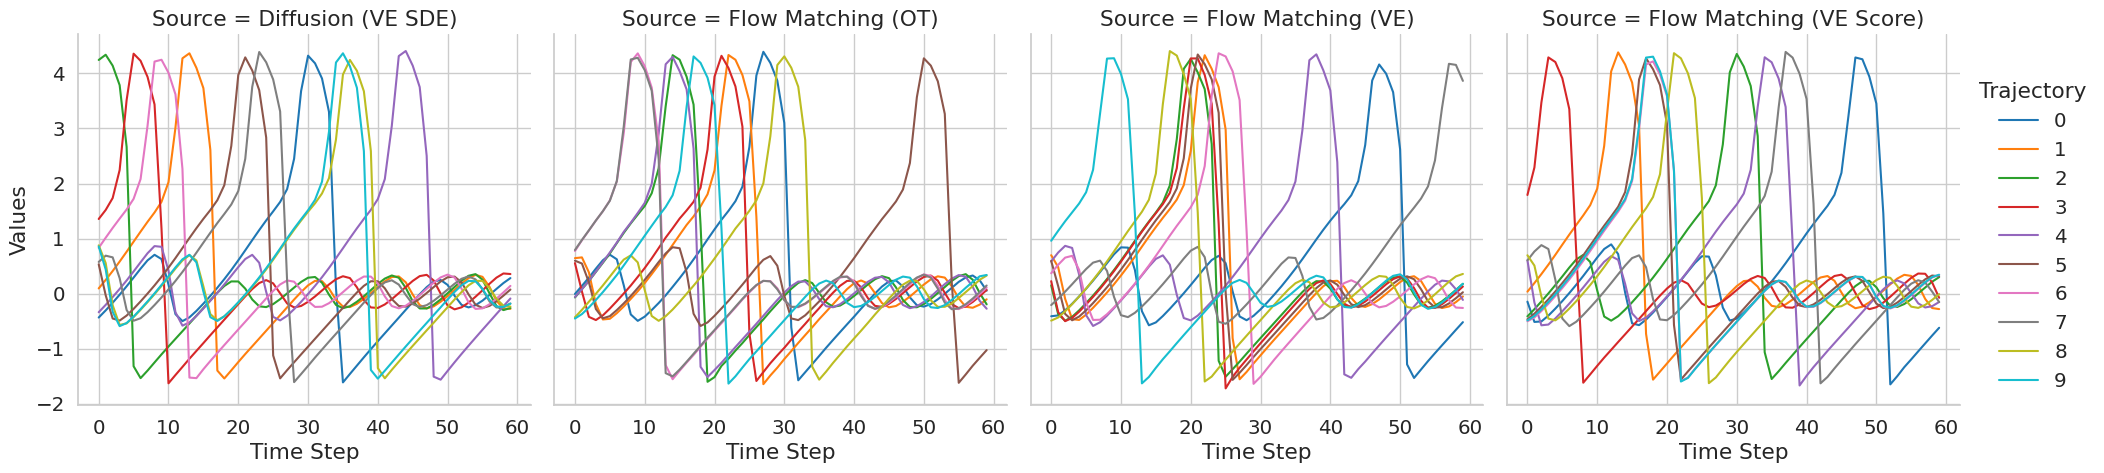

In [13]:
trajectory_count = 10
df = pd.concat([
    *itertools.chain.from_iterable([
        [
            pd.DataFrame(dict(
                Source=source,
                Values=trajectory[:, 0],
            ))
            for i, trajectory in zip(range(trajectory_count), info['samples'][constraint(info['samples']) > 0])
        ]
        for (_, source), info in cfg_info.items()
    ])
], axis=0, keys=len(cfg_info) * list(map(str, range(trajectory_count)))).reset_index(names=['Trajectory', 'Time Step'])
sns.relplot(
    kind='line',
    data=df,
    x='Time Step', y='Values',
    hue='Trajectory',
    col='Source',
    col_order=[c[1] for c in cfg_info],
)
print('Model-sampled events')

Data


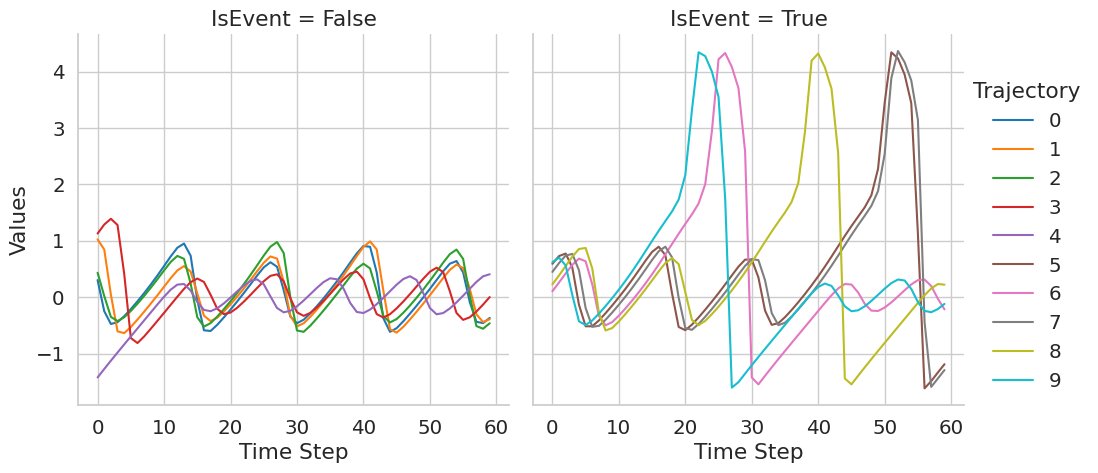

In [14]:
trajectory_count = 5
df = pd.concat([
    *[
        pd.DataFrame(dict(
            IsEvent=False,
            Values=trajectory[:, 0]
        )) for i, trajectory in zip(
            range(trajectory_count),
            evaluation_trajectories[constraint(evaluation_trajectories) <= 0]
        )
    ],
    *[
        pd.DataFrame(dict(
            IsEvent=True,
            Values=trajectory[:, 0]
        )) for i, trajectory in zip(
            range(trajectory_count),
            evaluation_trajectories[constraint(evaluation_trajectories) > 0]
        )
    ],
], axis=0, keys=map(str, range(2 * trajectory_count))).reset_index(names=['Trajectory', 'Time Step'])
sns.relplot(
    kind='line',
    data=df,
    x='Time Step', y='Values',
    hue='Trajectory',
    col='IsEvent',
)
print('Data')

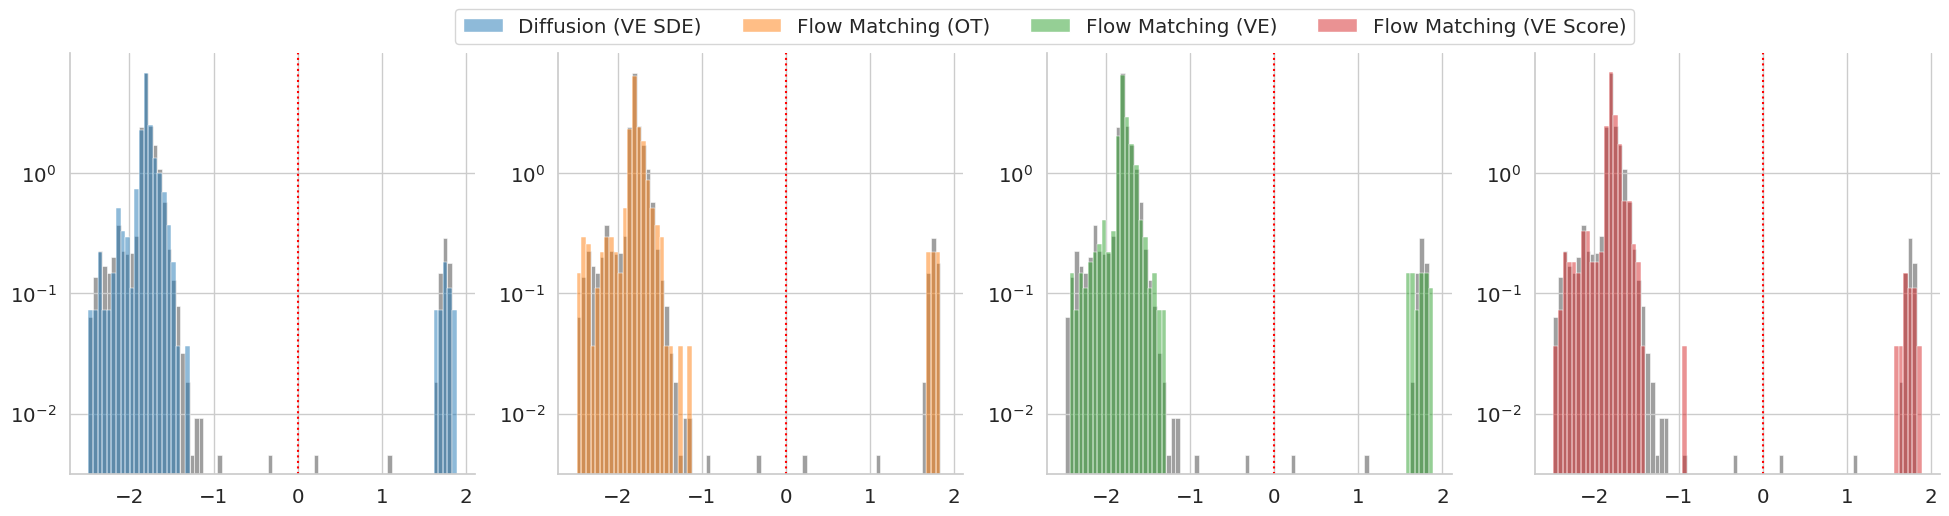

In [15]:
df = pd.concat([
    pd.Series(constraint(info['samples']), name=source)
    for (_, source), info in cfg_info.items()
], axis=1).melt(var_name='Source', value_name='Constraint Value')
df_data = pd.DataFrame({'Source': 'Data', 'Constraint Value': constraint(splits['train'])})
bins = np.histogram(np.zeros(2), bins=80, range=pd.concat((df, df_data))['Constraint Value'].agg(['min', 'max']))[1]
plot = (
    sns.displot(
        data=df,
        stat='density',
        x='Constraint Value',
        col='Source',
        col_order=[c[1] for c in cfg_info],
        hue='Source',
        hue_order=[c[1] for c in cfg_info],
        common_norm=False,
        bins=bins,
        facet_kws=dict(
            # sharey=False,
        )
    )
    .set(yscale='log' if isinstance(reference_cfg.dataset, cs.DatasetFitzHughNagumo) else 'linear')
    .set_titles('')
)
plot.map(
    sns.histplot,
    data=df_data,
    bins=bins,
    stat='density',
    color='tab:grey',
    x='Constraint Value',
    zorder=-1,
).set_xlabels('').set_ylabels('')
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    ax.axvline(x=0, c='r', ls=':')
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)
plot.tight_layout()
sns.move_legend(
    plot,
    loc='upper center',
    ncol=len(cfg_info) + 1,
    title='',
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)

In [16]:
plots.save_all_subfigures(plot, f'event_histogram.unconditional.{reference_cfg.dataset.__class__.__name__}')

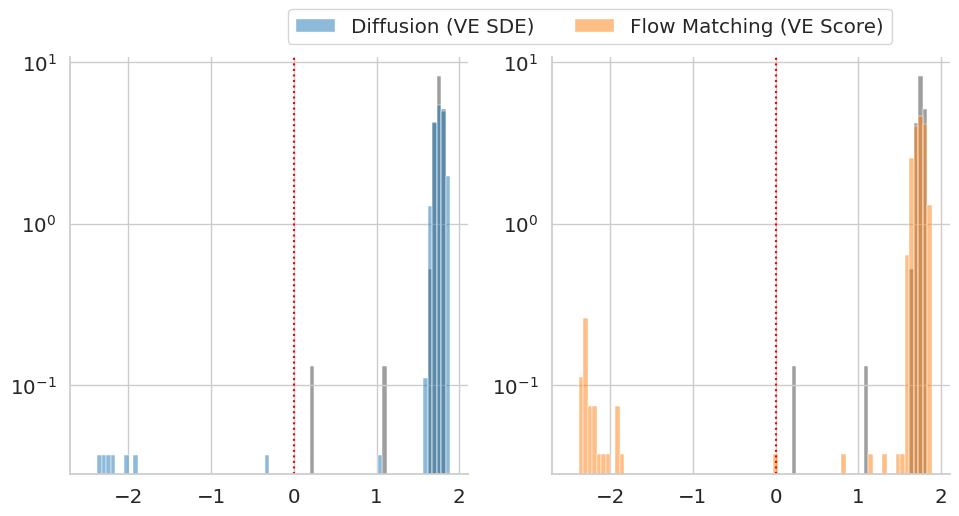

In [17]:
df = pd.concat([
    pd.Series(constraint(info['event_samples']), name=source)
    for (_, source), info in cfg_info.items()
    if 'event_samples' in info
], axis=1).melt(var_name='Source', value_name='Constraint Value')
# reuse bins from previous plot
plot = (
    sns.displot(
        data=df,
        stat='density',
        x='Constraint Value',
        col='Source',
        col_order=[c[1] for c, info in cfg_info.items() if 'event_samples' in info],
        hue='Source',
        hue_order=[c[1] for c, info in cfg_info.items() if 'event_samples' in info],
        common_norm=False,
        bins=bins,
        facet_kws=dict(
            # sharey=False,
        )
    )
    .set(yscale='log' if isinstance(reference_cfg.dataset, cs.DatasetFitzHughNagumo) else 'linear')
    .set_titles('')
)
plot.map(
    sns.histplot,
    data=pd.DataFrame({'Source': 'Data', 'Constraint Value': constraint(splits['train'][constraint(splits['train']) > 0])}),
    bins=bins,
    stat='density',
    color='tab:grey',
    x='Constraint Value',
    zorder=-1,
).set_xlabels('').set_ylabels('')
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    ax.axvline(x=0, c='r', ls=':')
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)
plot.tight_layout()
sns.move_legend(
    plot,
    loc='upper center',
    ncol=len(cfg_info) + 1,
    title='',
    bbox_to_anchor=(.455, 1.06),
    frameon=True,
    fancybox=True,
)

In [18]:
plots.save_all_subfigures(plot, f'event_histogram.conditional.{reference_cfg.dataset.__class__.__name__}')